In [22]:
""" Plots figures for LED classifier analysis
    and multiple linear regression analysis
"""

' Tone-LED Classifier\n'

In [3]:
import sys
import os
import random
# sys.path.append('B:/code/cshearer/py/')
# sys.path.append('B:/code/shared/')
#sys.path.append('../cshearer/py/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cs_basefunctions as cms
from scipy.stats import zscore,ttest_1samp,sem
import inference_task as inf
from matplotlib.lines import Line2D
import scipy.stats
import seaborn as sns
import statannot
from scipy.stats import bootstrap
import statsmodels.api as sm
import difference_estimation_plot as diff_plot


#l_pal = {'L23':'#FFC107', 'L56':'#1E88E5', 'Difference': '#A4C639'}

from helper_functions import *
sample_rate, ca_sample_rate = cms.sample_rate, cms.ca_sample_rate
# load layer coordinates
layer_split_df = pd.read_csv('layer_x_coordinates.csv')

l_pal = {'L23':'#F83B07', 'L56':'#1E88E5', 'Difference': '#A4C639'}
l_cols = ['#F83B07','#1E88E5']


In [4]:
import statsmodels.api as sm

In [5]:
# Plotting functions

import difference_estimation_plot as diff_plot

def lmplot(df, title='', aspect = 1.2, col=None):
    plt.figure()
    sns.lmplot(data = df, x = 'day', y = 'accs', hue = 'layer',col=col,
               palette = l_pal, aspect = aspect, ci = 95)
    plt.axhline(y = 0, color='black', linestyle = '--')
    if title:
        plt.title(title)
    plt.ylabel('Balanced Accuracy')
    plt.xlabel('Recording Day')

    
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='L23', markerfacecolor=l_pal['L23'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='L56', markerfacecolor=l_pal['L56'], markersize=10)]

def layerbarplot(ax, data, pairs, title, xvar = 'acc_type', xlabel = None, test = 'Wilcoxon'):

    sns.stripplot(data = data, y = 'accs', x = xvar, hue = 'layer', 
                  dodge = True, palette='dark:black', ax =ax)
    sns.barplot(data = data, y = 'accs', x = xvar, hue = 'layer',
                  palette = l_pal, errorbar = ('ci',  95), capsize = 0.1, ax=ax)
    if pairs:
        statannot.add_stat_annotation(ax, data = data, y = 'accs', x= xvar,hue = 'layer',
                                     box_pairs = pairs, 
                                      test = test, text_format = 'star')

    ax.axhline(y=0, color = 'black', linestyle='--')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Balanced Accuracy')
    
# Stats functions

def ols_stats(dff, drop_cols = ['accs']):
    dummy_df = pd.get_dummies(dff, drop_first=True)

    X = dummy_df.drop(columns=drop_cols)
    Y = dummy_df.accs
    #.astype(float)
    X = sm.add_constant(X)
    res = sm.OLS(Y,X).fit()
    print(res.summary())


# Figure 3
Results of LED-LED decoding analysis


In [6]:
# read data
all_al = pd.read_csv('results/LED_Classifier/all_cells/AL_tone_led_230602.csv', index_col = 0)
all_inf_led = pd.read_csv('results/LED_Classifier/all_cells/INF_led_correct_230604.csv', index_col = 0)
all_inf_led_inc = pd.read_csv('results/LED_Classifier/all_cells/INF_led_incorrect_230609.csv', index_col = 0)

                            OLS Regression Results                            
Dep. Variable:                   accs   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1.825
Date:                Mon, 31 Jul 2023   Prob (F-statistic):              0.134
Time:                        11:56:01   Log-Likelihood:                 12.360
No. Observations:                  40   AIC:                            -12.72
Df Residuals:                      34   BIC:                            -2.587
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1671      0.080      2.079   

<Figure size 640x480 with 0 Axes>

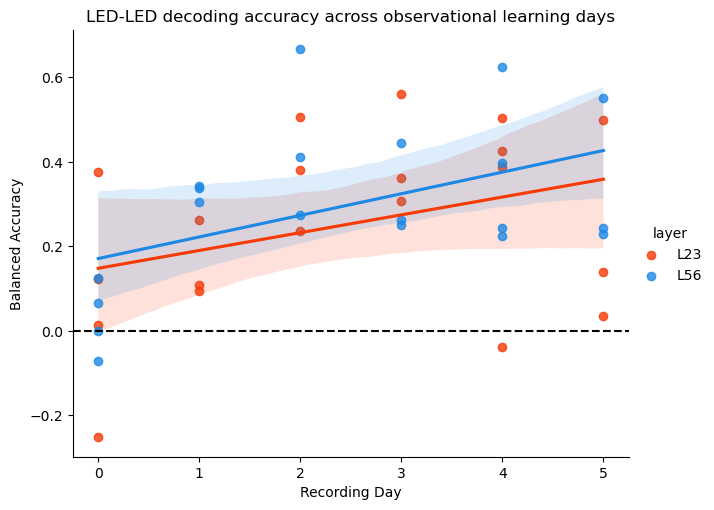

In [7]:
# Fig 3A

# select LED-LED classifier results
all_al_led = all_al[all_al.acc_type == 'led'].copy()

# plot accuracy across learning days
lmplot(df = all_al_led, title='LED-LED decoding accuracy across observational learning days', aspect = 1.3)
# save 
plt.savefig('figures/fig3A')

# get statistics
ols_stats(all_al_led, drop_cols = ['accs'])

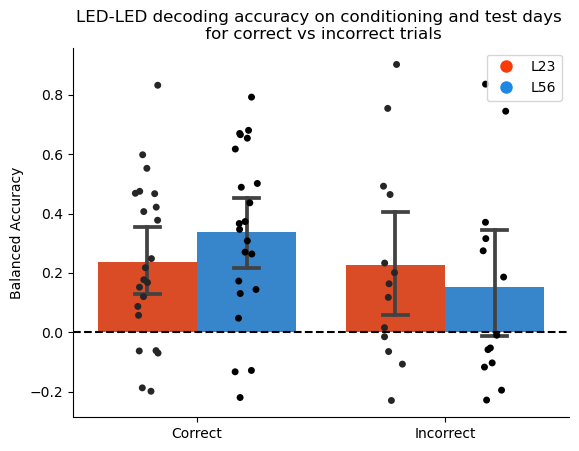

In [8]:
# Fig 3B

# pool correct and incorrect inference trials
all_inf_led['correct'] = ['Correct']*all_inf_led.shape[0]
all_inf_led_inc['correct'] = ['Incorrect']*all_inf_led_inc.shape[0]
allcor = pd.concat([all_inf_led, all_inf_led_inc])
p = [(('Correct', 'L23'),('Incorrect', 'L23')), (('Correct', 'L56'),('Incorrect', 'L56'))]

# plot
fig, ax = plt.subplots()
layerbarplot(ax=ax, data = allcor, xvar = 'correct',
             pairs = None, title = 'LED-LED decoding accuracy on conditioning and test days \n for correct vs incorrect trials', test = 'Mann-Whitney')
ax.legend(handles = legend_elements)
sns.despine()
# save
plt.savefig('figures/fig3B')

# Figure 4
Results of tone-LED decoding analysis

In [9]:
# read data for tone active cell analysis

# observational learning
tone_led_al = pd.read_csv('results/LED_Classifier/tone_active/AL_tone_led_230605.csv', index_col = 0)
tone_al = tone_led_al[tone_led_al.acc_type == 'tone']

# inference test 
tone_inf = pd.read_csv('results/LED_Classifier/tone_active/INF_tone_correct_230613.csv', index_col = 0)
tone_inf_inc = pd.read_csv('results/LED_Classifier/tone_active/INF_tone_incorrect_230609.csv', index_col = 0)


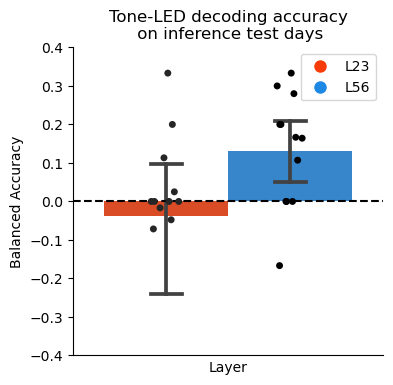

In [11]:
# Fig 4A: Tone-LED decoding accuracy on inference test days

# select decoding accuracy for neural response during the tone period (t1)
# correct trials
t1_inf = tone_inf[tone_inf.acc_type == 't1'].copy()
cor = tone_inf[tone_inf.acc_type == 't1'].copy()
cor['correct'] = 'Correct'
# incorrect trials
incor = tone_inf_inc[tone_inf_inc.acc_type == 't1'].copy()
incor['correct'] = 'Incorrect'
# pool correct and incorrect
corrs = pd.concat([cor, incor])

# plot
fig, ax = plt.subplots(figsize = (4,4))
layerbarplot(ax=ax, data = cor, pairs = None, title = 'Tone-LED decoding accuracy\n on inference test days')
ax.legend(handles = legend_elements)
ax.set_xticks([])
ax.set_xlabel('Layer')
ax.set_ylim(-0.4, 0.4)
sns.despine()
# save
plt.savefig('figures/fig4A')

B:\code/shared\difference_estimation_plot.py:138: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x_, y_, markers[n + x_ind],


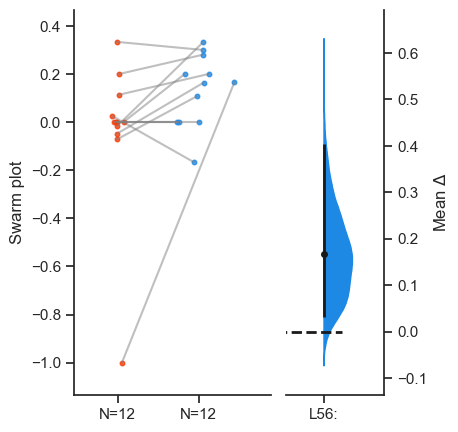

In [13]:
# Fig 4B: Bootstrap mean difference plot

import difference_estimation_plot as diff_plot

df = t1_inf.copy()

# format data
input_dict = {'L23':np.array(df[(df.acc_type == 't1')&(df.layer == 'L23')].accs),
             'L56:':np.array(df[(df.acc_type == 't1')&(df.layer == 'L56')].accs)}
input_conds = [list(input_dict.keys())]

# plot
ax,stat,p = diff_plot.estimation_plot(input_dict,input_conds,paired=True, color_palette = l_cols, vertical=0)
# save
plt.savefig('figures/fig4B')

                            OLS Regression Results                            
Dep. Variable:                   accs   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     3.644
Date:                Mon, 31 Jul 2023   Prob (F-statistic):             0.0101
Time:                        11:57:36   Log-Likelihood:                 31.706
No. Observations:                  38   AIC:                            -51.41
Df Residuals:                      32   BIC:                            -41.59
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0856      0.050      1.724   

<Figure size 640x480 with 0 Axes>

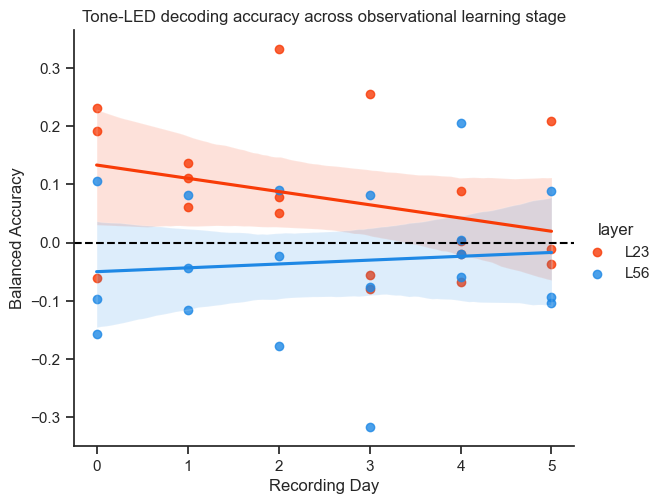

In [14]:
# Fig 4C: Tone-LED decoding accuracy across observational learning stage

# Plot tone-led decoding across recording days
lmplot(df = tone_al[tone_al.acc_type == 'tone'], aspect = 1.2, title = 'Tone-LED decoding accuracy across observational learning stage')
# save
plt.savefig('figures/fig4C')

# multiple linear regression stats
ols_stats(tone_al[(tone_al.acc_type == 'tone')], drop_cols = ['accs'])

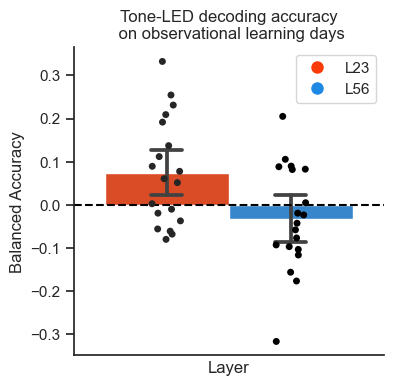

In [15]:
# Fig 4D: Tone-LED decoding accuracy on observational learning days pooled

fig, ax = plt.subplots(figsize = (4,4))
layerbarplot(ax=ax, data = tone_al[tone_al.acc_type == 'tone'], pairs = None, title = 'Tone-LED decoding accuracy\n on observational learning days')
ax.legend(handles = legend_elements)
ax.set_xticks([])
ax.set_xlabel('Layer')
sns.despine()
# save
plt.savefig('figures/fig4D')

In [16]:
# multiple linear regression
ols_stats(tone_al)
# wilcoxon test
print('L23: ', scipy.stats.wilcoxon(tone_al[(tone_al.layer == 'L23')].accs))
print('L56: ', scipy.stats.wilcoxon(tone_al[(tone_al.layer == 'L56')].accs))
print('L23: ', scipy.stats.ttest_1samp(tone_al[(tone_al.layer == 'L23')].accs, 0))
print('L56: ', scipy.stats.ttest_1samp(tone_al[(tone_al.layer == 'L56')].accs, 0))

                            OLS Regression Results                            
Dep. Variable:                   accs   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     3.644
Date:                Mon, 31 Jul 2023   Prob (F-statistic):             0.0101
Time:                        11:57:42   Log-Likelihood:                 31.706
No. Observations:                  38   AIC:                            -51.41
Df Residuals:                      32   BIC:                            -41.59
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0856      0.050      1.724   

# Supplementary Figures

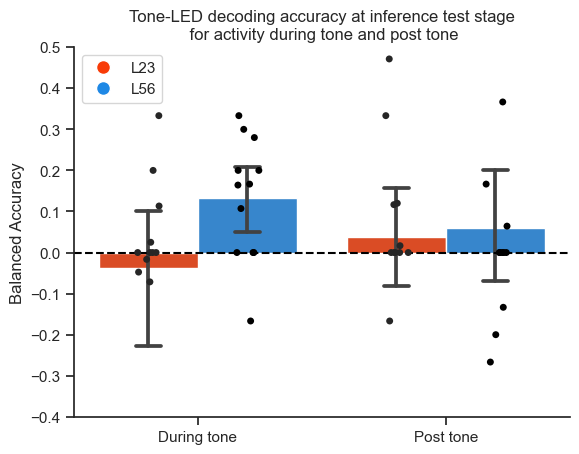

In [19]:
#### S1 Tone-LED decoding accuracy at inference test stage for activity during tone and post tone
fig, ax = plt.subplots()
p = [(('t1', 'L23'),('t1','L56')), (('t2', 'L23'),('t2','L56'))]
layerbarplot(ax=ax, data = tone_inf, pairs = None, title = 'Tone-LED decoding accuracy at inference test stage\n for activity during tone and post tone')
ax.set_ylim(-0.4, 0.5)
ax.set_xticks([0,1], ['During tone','Post tone'])
ax.legend(handles = legend_elements)
sns.despine()
plt.savefig('figures/figS1')

In [18]:
# looking at t1 tone period
t1_inf = tone_inf[tone_inf.acc_type == 't1'].copy()
t1_inf['stage'] = ['test']*t1_inf.shape[0]
print('Correct trials on INFERENCE days: layer decodability above zero?')
print('L56: ', scipy.stats.ttest_1samp(t1_inf[t1_inf.layer == 'L56'].accs, 0))
print('L23: ', scipy.stats.ttest_1samp(t1_inf[t1_inf.layer == 'L23'].accs, 0))

# incorrect trials
cor = tone_inf[tone_inf.acc_type == 't1'].copy()
cor['correct'] = 'Correct'
incor = tone_inf_inc[tone_inf_inc.acc_type == 't1'].copy()
incor['correct'] = 'Incorrect'
corrs = pd.concat([cor, incor])

# statistics for incorrect trials
print('Inorrect trials on INFERENCE days: layer decodability above zero?')
print('L56: ', scipy.stats.ttest_1samp(incor[incor.layer == 'L56'].accs, 0))
print('L23: ', scipy.stats.ttest_1samp(incor[incor.layer == 'L23'].accs, 0))


Correct trials on INFERENCE days: layer decodability above zero?
L56:  TtestResult(statistic=3.0701192519139515, pvalue=0.010657647342085207, df=11)
L23:  TtestResult(statistic=-0.41353486564539077, pvalue=0.6871622761059766, df=11)
Inorrect trials on INFERENCE days: layer decodability above zero?
L56:  TtestResult(statistic=0.657184242442385, pvalue=0.5785800634039527, df=2)
L23:  TtestResult(statistic=-1.0843872765171645, pvalue=0.39151301554066875, df=2)


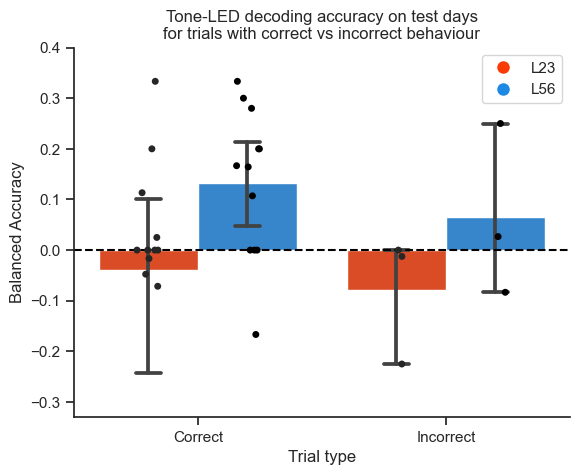

In [21]:
#### S2 Tone-LED decoding accuracy at inference test stage for trials with correct vs incorrect behaviour

p = [ (('correct', 'L56'),('incorrect','L56'))]

fig, ax = plt.subplots()
layerbarplot(ax, corrs, None, 'Tone-LED decoding accuracy on test days\nfor trials with correct vs incorrect behaviour', xvar = 'correct', xlabel = None, test = 'Mann-Whitney')
ax.set_ylim(-0.33, 0.4)
ax.legend([])
plt.legend(handles = legend_elements)
ax.set_xlabel('Trial type')
sns.despine()
plt.savefig('figures/figS2')